/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_24985/1392644334.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_micro_incl = df_micro_all[(df_micro_all['conc'] < 40) &


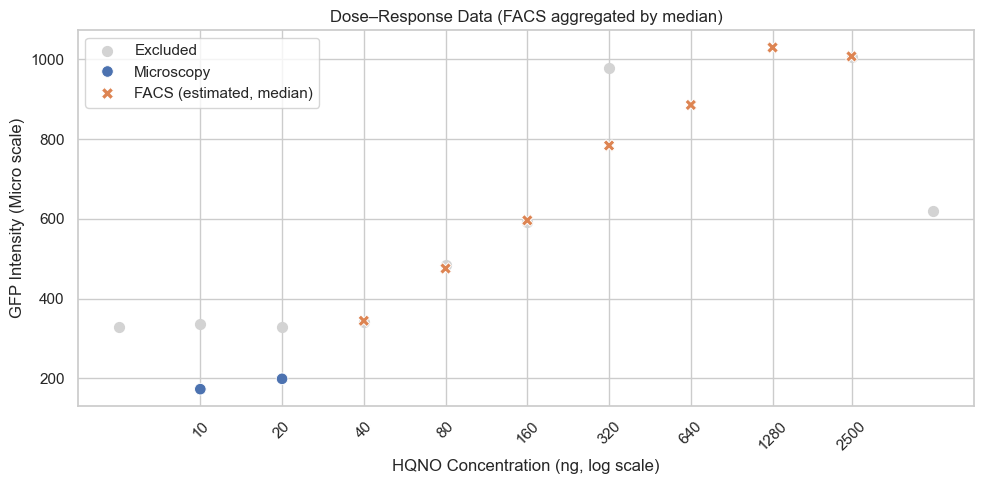

Saved CSVs to: /Users/simonvanvliet/Library/CloudStorage/Dropbox/Work/Code/Spatial Tolerance Model/2DModel/0_calibration_curves_hqno


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path

data_folder = Path.cwd().parents[1] / 'datafiles'

# ——— Configuration ———
FACS_CSV    = data_folder / 'hqno_calibration_facs.csv'
MICRO_CSV   = data_folder / 'hqno_calibration_microscopy.csv'
PREDICTED_CSV = Path.cwd() / 'hqno_facs_transformed.csv'


HQNO_ORDER     = [
    'HQNO_0','HQNO_5','HQNO_10','HQNO_20','HQNO_40','HQNO_80',
    'HQNO_160','HQNO_320','HQNO_640','HQNO_1280','HQNO_2500','HQNO_5000'
]
COMPARE_LEVELS = ['HQNO_40','HQNO_80','HQNO_160','HQNO_320','HQNO_2500']

# ——— Load & preprocess raw data ———
facs = pd.read_csv(FACS_CSV)
facs['HQNO'] = pd.Categorical(facs['HQNO'], categories=HQNO_ORDER, ordered=True)

micro = pd.read_csv(MICRO_CSV)
micro['HQNO'] = (
    micro['HQNO']
         .str.replace('_ng','', regex=False)
         .astype(pd.CategoricalDtype(HQNO_ORDER, ordered=True))
)

# ——— Compute microscopy medians & summarization ———
micro_med = (
    micro
    .groupby(['HQNO','pos'], observed=True)['intensity_raw_gfp']
    .median()
    .reset_index(name='median_gfp')
)

merged = pd.merge(micro_med, facs, on='HQNO', suffixes=('_micro','_facs'))
agg = (
    merged
    .groupby('HQNO', observed=True)
    .agg(
        median_x=('median_gfp_micro','median'),
        p20_x   =('median_gfp_micro', lambda s: np.percentile(s,20)),
        p80_x   =('median_gfp_micro', lambda s: np.percentile(s,80)),
    )
    .reset_index()
)
agg['x_err_low']  = agg['median_x'] - agg['p20_x']
agg['x_err_high'] = agg['p80_x'] - agg['median_x']

# ——— Load pre-computed FACS→microscopy values ———
pred = pd.read_csv(PREDICTED_CSV)
pred['HQNO'] = pd.Categorical(pred['HQNO'], categories=HQNO_ORDER, ordered=True)

# ——— NEW: collapse FACS→microscopy to median per concentration ———
pred_med = (
    pred
    .groupby('HQNO', observed=True)['predicted_micro_gfp']
    .median()
    .reset_index(name='median_gfp')
)

# ——— Build “all” DataFrames (microscopy medians + FACS medians) ———
df_micro_all = agg[['HQNO','median_x']].rename(columns={'median_x':'GFP'})
df_micro_all['Source'] = 'Microscopy'
df_micro_all['conc'] = (
    df_micro_all['HQNO'].astype(str)
                  .str.replace('HQNO_','')
                  .astype(float)
)

df_pred_all = pred_med.rename(columns={'median_gfp':'GFP'})
df_pred_all['Source'] = 'FACS (estimated, median)'
df_pred_all['conc'] = (
    df_pred_all['HQNO'].astype(str)
                  .str.replace('HQNO_','')
                  .astype(float)
)

# ——— Split into included vs excluded ———
df_micro_incl = df_micro_all[(df_micro_all['conc'] < 40) &
                             (df_pred_all['conc'] > 0)]
df_micro_excl = df_micro_all[df_micro_all['conc'] >= 40]

df_pred_incl = df_pred_all[
    (df_pred_all['conc'] >= 40) &
    (df_pred_all['conc'] <= 2500)
]
df_pred_excl = df_pred_all[
    (df_pred_all['conc'] >= 0) &
    ~((df_pred_all['conc'] >= 40) & (df_pred_all['conc'] <= 2500))
]

# ——— Prepare data for Hill fit (only included) ———
df_plot = pd.concat([df_micro_incl, df_pred_incl], ignore_index=True)
df_plot['HQNO'] = pd.Categorical(df_plot['HQNO'],
                                 categories=HQNO_ORDER,
                                 ordered=True)


x_data = df_plot['conc'].values
y_data = df_plot['GFP'].values



# ——— Plot: excluded in gray, included colored, plus Hill curve ———
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))

# excluded points
plt.scatter(df_micro_excl['conc'], df_micro_excl['GFP'],
            color='lightgray', s=50, label='Excluded')
plt.scatter(df_pred_excl['conc'], df_pred_excl['GFP'],
            color='lightgray', s=50)

# included points
sns.scatterplot(data=df_plot, x='conc', y='GFP',
                hue='Source', style='Source', s=70)


plt.xscale('log')
plt.xlabel('HQNO Concentration (ng, log scale)')
plt.ylabel('GFP Intensity (Micro scale)')
plt.title('Dose–Response Data (FACS aggregated by median)')
plt.xticks(
    ticks=sorted(df_plot['conc'].unique()),
    labels=[str(int(v)) for v in sorted(df_plot['conc'].unique())],
    rotation=45
)
plt.legend(title='')
plt.tight_layout()
plt.savefig('SUPP_included_and_excluded_data.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


# === Save data to CSV ===
import os

# Put outputs next to your input CSVs (change if you prefer)
OUTPUT_DIR = Path.cwd()

# 1) All raw points shown in the scatter (microscopy medians + FACS medians)
OUTPUT_ALL_POINTS = os.path.join(OUTPUT_DIR, 'hqno_dose_response_all_points.csv')
df_all_points = pd.concat([df_micro_all, df_pred_all], ignore_index=True)
df_all_points.to_csv(OUTPUT_ALL_POINTS, index=False)

# 2) Points actually used in the fit (included only)
OUTPUT_INCLUDED_POINTS = os.path.join(OUTPUT_DIR, 'hqno_dose_response_included_points.csv')
df_plot.to_csv(OUTPUT_INCLUDED_POINTS, index=False)


print("Saved CSVs to:", OUTPUT_DIR)